# Progetto Python

Negli ultimi la comunità del dominio e-learning ha prodotto una quantità significativa 
di risorse didattiche eterogenee. Data la grande quantità di informazione prodotta è stato deciso di creare degli standard utili alla gestione e strutturazione delle risorse. Lo standard principalmente utilizzato è noto come lo standard LOM (Learning Object Metadata) di IEEE nato del 2002. Mediante lo standard risulta possibile associare 72 features ad ogni Learning Object (LO) e 9 aree descrittive, le quali sono utili per categorizzare il contenuto semantico informativo presente nella risorsa didattica.
 
Nell’insieme di features associati ad ogni LO è possibile inserire dei metadati, i quali sono rilevanti per affrontare le problematiche legate alla classificazione e gestione del contenuto informativo. In particolare, in diversi ambiti applicativi sono stati rilasciati sistemi intelligenti per l’elaborazione dell’informazione dei LOs, e tra i principali sistemi sono presenti modelli di NLP per la classificazione automatica e Sistemi di raccomandazione.  L’utilizzo di questi algoritmi ha portato alla ricerca di nuovi modelli per affrontare diversi task sui LOs.
 
Una delle operazioni che possono essere svolte sui Learning Objects e sulla connessione tra questi è sicuramente analizzare la relazione di prerequisito esistente tra questi. 
Il problema può essere formalizzato come una funzione binaria che determina se due LOs sono in relazione e quale deve essere prerequisito dell’altro. **Un concetto A è prerequisito di un concetto B, se A è necessario o significativamente utile per comprendere B.**

Nella prima fase del progetto ci si focalizza sul cercare delle metodologie di Topic Modeling per estrarre quelli che sono i topic caratterizzanti di ciascuna risorsa didattica. Successivamente per questi topic verranno estratte le informazioni da wikipedia, in modo da dare un contesto e da poter avere una base per la fase successiva di embedding dei contenuti. La fase finale prevede la creazione di una rete neurale feed forward per poter definire delle relazioni di prerequisito tra learning objects.

Una volta eseguita questa prima parte, quello che deve essere fatto è replicare la metodologia proposta da Angel et al., la quale consiste in una Neural Network Single Layer addestrata usando delle rappresentazioni di coppie di concetti estratte usando un BERT italian model sul quale è stato eseguito un fine-tuning usando il dataset ITA-PREREQ, il quale contiene coppie di concetti italiani legati da una relazione di prerequisiti.
Allo stesso modo, nel mio caso prevedo  di effettuare un fine-tuning di BERT usando le coppie di testi di wikipedia estratti e ricevere in output label 0 e 1. Successivamente utilizzare questo modello pre-addestrato ed estenderlo alle coppie di learning objects per prevedere la relazione di prerequisito.

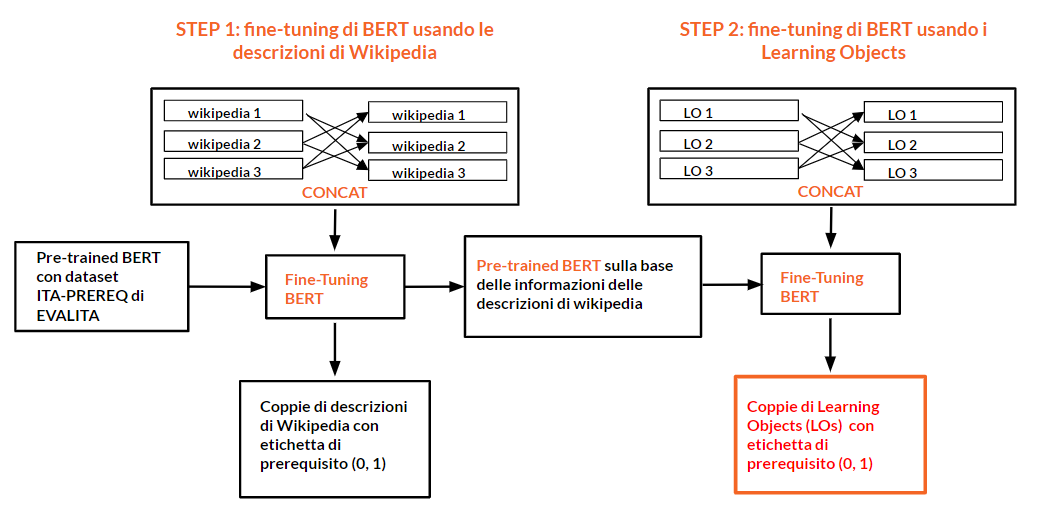

In [16]:
from IPython.display import display, Image
display(Image(filename='bert_fine_tuning.png'))

In [1]:
import pandas as pd
import os

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess

import re
import tqdm

import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
os.chdir(r"C:\Users\andre\OneDrive\Desktop\DATA\INFO PREREQUISITI")

## Caricamento e pulizia dataset

Le prime operazioni da svolgere riguardano la pulizia del dataset. I dati sono stati estratti dai database online di OER (Open Educational Resources) e MERLOT. Il dataset complessivo è composto da oltre 98.000 risorse didattiche, per questo motivo ho deciso di usare solo una parte di questo. Precisamente sono state mantenute i record dove la feature 
'language' == 'English', e la disciplina rientrasse tra informatica, matematica e scienze, statistica e computer science.
Il dataset risultante è composto da 32853 risorse (37% di quello iniziale).

In [2]:
datasetM = pd.read_csv(r"C:\Users\andre\OneDrive\Desktop\DATA\INFO PREREQUISITI\Merlot_V03.3.csv", sep=";")
datasetM = datasetM.drop(columns = ['keywords', 'type',
                                    'upload_date', 'difficulty', 'format', 'duration',
                                    'destination_public', 'min_age', 'max_age'])

datasetO = pd.read_csv(r"C:\Users\andre\OneDrive\Desktop\DATA\INFO PREREQUISITI\OERformattato (1).csv", sep=";")
datasetO = datasetO.drop(columns = ['keywords', 'type',
                                    'upload_date', 'difficulty', 'format', 'duration',
                                    'destination_public', 'min_age', 'max_age'])

dataset = pd.concat([datasetM, datasetO], axis=0)
dataset = dataset.reset_index()

general_dataset = dataset.drop(columns = ['index']) #shape (98597, 3)
general_dataset = general_dataset.query("language == 'English'") #shape (86947, 3)

**Rappresentazione grafica del dataset e delle sue proprietà.**

In [3]:
language_list = list(general_dataset['language'])
discipline_list = list(general_dataset['domain_level_0'])

def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
         hist[i] = hist.get(i, 0) + 1
    return hist

counted_l = count_elements(language_list)
counted_d = count_elements(discipline_list)

counted_l = dict(sorted(counted_l.items(), key=lambda item: item[1]))
counted_d = dict(sorted(counted_d.items(), key=lambda item: item[1]))

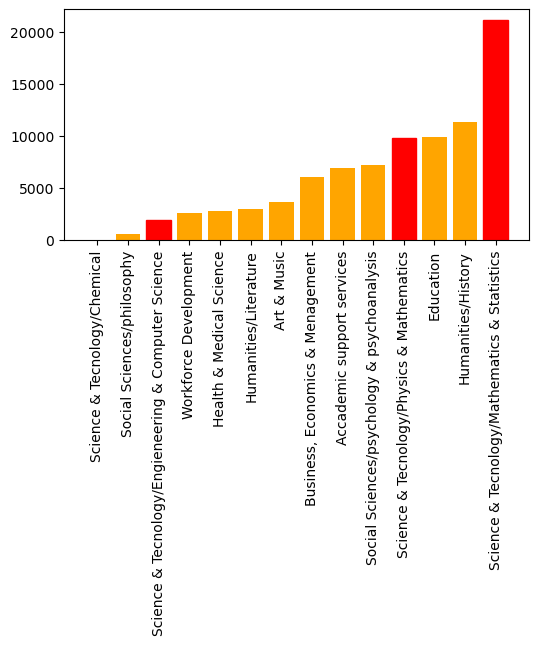

In [4]:
fig, ax = plt.subplots(figsize = (6,3))
hist = plt.bar(counted_d.keys(), counted_d.values(), color='orange')
hist[2].set_color('r')
hist[10].set_color('r')
hist[13].set_color('r')
plt.xticks(rotation=90)

plt.show()

In [ ]:
disciplineslist = general_dataset.domain_level_0.unique()
disciplineslist.sort()
for i in disciplineslist:
    print(i)

In [5]:
info_dataset = general_dataset.query('domain_level_0.str.contains("Science & Tecnology/Engieneering & Computer Science")| domain_level_0.str.contains("Science & Tecnology/Mathematics & Statistics")| domain_level_0.str.contains("Science & Tecnology/Physics & Mathematics")')
info_dataset = info_dataset.drop(columns = 'domain_level_0')
info_dataset = info_dataset.reset_index()

In [6]:
info_dataset = info_dataset.drop(columns=['index', 'language'])

texts = []
for index, row in info_dataset.iterrows():
    text = row['description']
    text = str(text)
    texts.append(text)

info_dataset['description'] = texts

In [8]:
info_dataset.head()

,URI,title,description
0,https://www.merlot.org/merlot/viewMaterial.htm...,Holiday STEM Activities for Kids,This resource includes activities that can int...
1,https://www.merlot.org/merlot/viewMaterial.htm...,Blockly Games,Blockly Games is a series of educational games...
2,https://www.merlot.org/merlot/viewMaterial.htm...,Day of AI,This resource is to support teachers and educa...
3,https://www.merlot.org/merlot/viewMaterial.htm...,Student Investigation Guide for Introduction t...,"In this book, you are going to engage in a ser..."
4,https://www.merlot.org/merlot/viewMaterial.htm...,Bridges to STEM Learning for Grades K-8,This course provides knowledge and skills in s...


Per semplificare delle operazioni future ho deciso di usare la libreria 're' per rimuovere la punteggiatura dal campo descrizione e per trasformare il carattere in lowercase. Inoltre, ho definito le funzioni per rimuovere le stopwords e per trasformare la stringa in una lista di singole parole. 

In [9]:
import re

info_dataset['text_preprocessed']=info_dataset['description'].map(lambda x: re.sub('[,.\!?]', '', x))
info_dataset['text_preprocessed']=info_dataset['description'].map(lambda x: x.lower())

stop_words = stopwords.words('english')
stop_words.extend(['student','course','use','will', 'students', 'data', 'lesson', 'lessons', 'learn', 'using', 'used'])

#funzione per rimuovere stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

#conversione stringa in singole parole (senza stopwords)
def sent_to_words(sentence):
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

Nel codice seguente sono state applicate le funzioni descritte precedentemente e sono state create delle ulteriori colonne nel nostro dataset.

In [10]:
description_words = []
for index, row in info_dataset.iterrows():
        data = row['text_preprocessed']
        if (data != '' or data != '-') :
            words = list(sent_to_words(data))
            words = remove_stopwords(words)
            description_words.append(words)

info_dataset['description'] = description_words

info_dataset = info_dataset.drop(columns = 'URI')
info_dataset.rename({'description': 'description_words'}, axis=1, inplace=True)

In [11]:
#dataset = info_dataset.drop(columns = 'description_words')
dataset = info_dataset
dataset = dataset.dropna(axis = 0)
dataset = dataset.reset_index()

In [13]:
dataset.head()

,index,title,description_words,text_preprocessed
0,0,Holiday STEM Activities for Kids,"[[resource, includes, activities, introduce, s...",this resource includes activities that can int...
1,1,Blockly Games,"[[blockly, games, series, educational, games, ...",blockly games is a series of educational games...
2,2,Day of AI,"[[resource, support, teachers, educators, run,...",this resource is to support teachers and educa...
3,3,Student Investigation Guide for Introduction t...,"[[book, going, engage, series, investigations,...","in this book, you are going to engage in a ser..."
4,4,Bridges to STEM Learning for Grades K-8,"[[provides, knowledge, skills, supporting, ste...",this course provides knowledge and skills in s...


In [14]:
clean_texts = []

for index, row in dataset.iterrows():
    data = row['text_preprocessed']
    clean_text = re.sub('''[1234567890]''', '', str(data))
    clean_texts.append(clean_text)

dataset['text_preprocessed'] = clean_texts

for index, row in dataset.iterrows():
    data = row['text_preprocessed']
    if len(data) < 15:
        dataset.drop(index = index, inplace = True)

In [15]:
dataset = dataset.reset_index()
dataset = dataset.drop(columns = ['index'])

In [ ]:
dataset = dataset.drop(columns = ['description_words'])

In [ ]:
dataset.to_csv('INFO_dataset_pre_LDA.csv')

Alla fine della fase di gestione del dataset abbiamo il seguente risultato. Le colonne che useremo per il topic modeling sono però solo quelle di titolo e testo preprocessato, le altre sono state create per motivi di comodità nel caso dovessero essere effettuate delle operazioni che le richiedessero.

In [20]:
dataset = pd.read_csv(r"C:\Users\andre\OneDrive\Desktop\DATA\INFO PREREQUISITI\INFO_dataset_pre_LDA.csv", index_col = 0)
dataset.head()

,title,text_preprocessed
0,Holiday STEM Activities for Kids,this resource includes activities that can int...
1,Blockly Games,blockly games is a series of educational games...
2,Day of AI,this resource is to support teachers and educa...
3,Student Investigation Guide for Introduction t...,"in this book, you are going to engage in a ser..."
4,Bridges to STEM Learning for Grades K-8,this course provides knowledge and skills in s...


## Applicazione LDA su Dataset informatica

Il topic modelling è un metodo di machine learning non supervisionato che riceve in input un corpus di documenti e ne estrae gli argomenti e concetti principali, permettendo di rappresentare grandi volumi di dati in dimensioni ridotte, grazie all’identificazione dei concetti nascosti, caratteristiche prominenti, variabili latenti e strutture semantiche dei dati.
Una volta creato il topic model, questo metodo ci permette di esprimere i documenti come una combinazione degli argomenti scoperti.

Uno dei limiti del topic modeling è che non ci sono indicazioni sulla qualità degli argomenti prodotti. Se si vuole sapere quanto sono significativi gli argomenti, è necessario valutare il modello. Le misure di coerenza assegnano un punteggio a un singolo argomento misurando il grado di somiglianza semantica tra le parole dell'argomento. Queste misure aiutano a distinguere tra argomenti interpretabili semanticamente e argomenti che sono artefatti dell'inferenza statistica.

La Latent Dirichlet Allocation (LDA) è uno degli approcci di topic modeling utilizzato nel Natural Language Processing (NLP) per scoprire gli argomenti sottostanti che sono presenti in una raccolta di documenti di testo. LDA è un modello probabilistico che rappresenta i documenti come una miscela di argomenti, dove ogni argomento è rappresentato da una distribuzione di parole. L'algoritmo presuppone che ogni documento sia una miscela di un numero fisso di topic e che ogni topic sia una distribuzione di probabilità sulle parole. Il modello utilizza un processo di inferenza per determinare la distribuzione dei topics in ciascun documento e la distribuzione delle parole in ciascun topic.

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32572 entries, 0 to 32571
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              32572 non-null  object
 1   text_preprocessed  32572 non-null  object
dtypes: object(2)
memory usage: 763.4+ KB


In [ ]:
def sent_to_words(sentence):
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) #converting the raw text into a list of tokens (words) deacc removes accents
    
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) #to remove stopwords
             if word not in stop_words] for doc in texts]

stop_words = stopwords.words('english')
stop_words.extend(['student','course','use','will', 'students', 'data', 'lesson', 'lessons', 'learn', 'using', 'used'])

La libreria usata per il modello è la libreria GENSIM, una libreria Python per la modellazione di argomenti, l'indicizzazione di documenti e il NLP in generale. La funzione per applicare LDA a un singolo elemento è la seguente. Tra le operazioni che vengono svolte sui singoli documenti abbiamo:

1) La classe **“Dictionary”** richiede un elenco di documenti come input, in cui ogni documento è rappresentato come un elenco di parole. Quindi crea un dizionario che associa ogni parola univoca nel corpus a un ID intero univoco. Questo dizionario può essere utilizzato per convertire i documenti di testo in bag-of-words, comunemente utilizzate nell'analisi del testo.

2) Il metodo **“doc2bow”** richiede un singolo argomento, che è un elenco di parole che compongono un documento. L'output sarà un elenco di tuple in cui ogni tupla contiene un ID di parola e il suo conteggio nel documento

3) Il parametro **“num_topics”** è il parametro K di LDA, il quale ci dice quanti topics vogliamo estrarre da ogni documento.

4) Il metodo **“LdaMulticore”** funziona addestrando un topic model su un corpus di documenti, in cui ogni documento è rappresentato come una bag-of-words. L'algoritmo individua un numero fisso di argomenti che meglio rappresentano il corpus. Il modello risultante contiene un insieme di argomenti, ognuno dei quali è rappresentato come una distribuzione di probabilità sulle parole nel corpus.

5) **"lda_model.print_topics”** è il metodo che viene utilizzato per stampare le prime parole e le probabilità associate per ogni argomento in un modello LDA addestrato. I parametri di questo metodo sono il numero di argomenti da restituire (di default tutti), e il numero di parole per argomento (di default 10). 

La seguente funzione mi restituisce per ogni documento 5 topics formati da 5 parole. Quello che useremo noi successivamente saranno le 5 parole del primo topic.

In [ ]:
def lda(words): #LDA to generate 5 topics of 5 words
    
    id2word = corpora.Dictionary(words)
    texts = words
    corpus = [id2word.doc2bow(text) for text in texts]
    num_topics = 5
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    

    return lda_model.print_topics(num_words=5)
    pprint(lda_model.print_topics(num_words=5))
    doc_lda = lda_model[corpus]

In [ ]:
topics = []

pbar = tqdm.tqdm(total=int(dataset.shape[0]))

def paral_lda(dataset):
    for index, row in dataset.iterrows():
    data = row['text_preprocessed']
    try:
        words = list(sent_to_words(data))
        words = remove_stopwords(words)
        topic = lda(words)
        topics.append(topic)
        print(f"{index}/{dataset.shape[0]}")
        pbar.update(1)
    except:
        topic = None
        topics.append(topic)

In [ ]:
paral_lda(dataset)

In [ ]:
dataset['lda_topics'] = topics
dataset['lda_topics']

In [ ]:
dataset = dataset.dropna(axis = 0)
dataset.info()

In [ ]:
single_topic = []
for index, row in dataset.iterrows():
    data = row['lda_topics'][0]
    single_topic.append(data)

dataset['lda_single_topic'] = single_topic
dataset['lda_single_topic'][0]

In [ ]:
cleantopicstr = []

for index, row in dataset.iterrows():
    data = row['lda_single_topic']
    clean_topic = re.sub('''[1234567890.*,()'" ]''', '', str(data))
    cleantopicstr.append(clean_topic)
    
dataset['single_topic'] = cleantopicstr

In [ ]:
topic_list = []

for index, row in dataset.iterrows():
    data = str(row['single_topic'])
    topic_words = re.split('[+]', data)
    topic_list.append(topic_words)

dataset['topic_list'] = topic_list

In [ ]:
for index, row in dataset.iterrows():
    data = row['topic_list']
    if len(data) < 5:
        dataset.drop(index = index, inplace = True)

In [ ]:
dataset = dataset.reset_index()

dataset = dataset.drop(columns = ['index'])

In [ ]:
parola_1 = []

for t in range(len(dataset['topic_list'])):

    word1 = dataset['topic_list'][t][0]
    parola_1.append(word1)

parola_1[:5]

In [ ]:
parola_2 = []

for t in range(len(dataset['topic_list'])):

    word2 = dataset['topic_list'][t][1]
    parola_2.append(word2)

parola_2[:5]

In [ ]:
parola_3 = []

for t in range(len(dataset['topic_list'])):

    word3 = dataset['topic_list'][t][2]
    parola_3.append(word3)

parola_3[:5]

In [ ]:
parola_4 = []

for t in range(len(dataset['topic_list'])):

    word4 = dataset['topic_list'][t][3]
    parola_4.append(word4)

parola_4[:5]

In [ ]:
parola_5 = []

for t in range(len(dataset['topic_list'])):

    word5 = dataset['topic_list'][t][4]
    parola_5.append(word5)

parola_5[:5]

In [ ]:
dataset['concept1'] = parola_1
dataset['concept2'] = parola_2
dataset['concept3'] = parola_3
dataset['concept4'] = parola_4
dataset['concept5'] = parola_5

In [25]:
dataset = pd.read_csv(r"C:\Users\andre\OneDrive\Desktop\DATA\INFO PREREQUISITI\INFO_dataset_pre_wiki.csv", index_col = 0)
dataset = dataset.drop(columns=['lda_single_topic','single_topic', 'topic_list'])
dataset.head()

,title,text_preprocessed,lda_topics,concept1,concept2,concept3,concept4,concept5
0,Holiday STEM Activities for Kids,this resource includes activities that can int...,"[(0, '0.111*""day"" + 0.111*""christmas"" + 0.111*...",day,christmas,thanksgiving,introduce,earth
1,Blockly Games,blockly games is a series of educational games...,"[(0, '0.030*""games"" + 0.030*""computer"" + 0.030...",games,computer,designed,blockly,collaborate
2,Day of AI,this resource is to support teachers and educa...,"[(0, '0.029*""ai"" + 0.029*""curriculum"" + 0.029*...",ai,curriculum,educators,activities,engage
3,Student Investigation Guide for Introduction t...,"in this book, you are going to engage in a ser...","[(0, '0.032*""investigations"" + 0.032*""question...",investigations,question,group,investigation,small
4,Bridges to STEM Learning for Grades K-8,this course provides knowledge and skills in s...,"[(0, '0.033*""throughout"" + 0.033*""engineering""...",throughout,engineering,math,macf,outofschool


## Estrazione delle descrizioni da Wikipedia

Arrivato a questo punto ho deciso di trovare un modo per estrarre delle descrizioni delle parole che meglio rappresentano ogni documento. Per fare ciò ho provato diversi metodi di scraping, ma alla fine la decisione è ricaduta sulla libreria 'wikipedia-api', che permette di estrarre le prime 400 parole dai testi di wikipedia collegati alle parole. L'operazione ha richiesto molto tempo viste le dimensioni del dataset e dato il fatto che wikipedia blocca le troppe chiamate da un singolo indirizzo IP.

In [2]:
dataset = pd.read_csv(r"C:\Users\andre\OneDrive\Desktop\DATA\INFO PREREQUISITI\INFO_dataset_pre_wiki.csv", index_col = 0)
dataset = dataset.drop(columns=['lda_topics','lda_single_topic','single_topic',	'topic_list'])
dataset.head() #28941 records con alcuni nulli

,title,text_preprocessed,concept1,concept2,concept3,concept4,concept5
0,Holiday STEM Activities for Kids,this resource includes activities that can int...,day,christmas,thanksgiving,introduce,earth
1,Blockly Games,blockly games is a series of educational games...,games,computer,designed,blockly,collaborate
2,Day of AI,this resource is to support teachers and educa...,ai,curriculum,educators,activities,engage
3,Student Investigation Guide for Introduction t...,"in this book, you are going to engage in a ser...",investigations,question,group,investigation,small
4,Bridges to STEM Learning for Grades K-8,this course provides knowledge and skills in s...,throughout,engineering,math,macf,outofschool


In [ ]:
!pip install wikipedia-api

In [ ]:
concept1, concept2, concept3, concept4, concept5 = list(dataset['concept1']), list(dataset['concept2']), list(dataset['concept3']), list(dataset['concept4']), list(dataset['concept5'])
conceptslist = [concept1, concept2, concept3, concept4, concept5]

wiki_concept1, wiki_concept2, wiki_concept3, wiki_concept4, wiki_concept5 = [],[],[],[],[]
wiki_concept = [wiki_concept1, wiki_concept2, wiki_concept3, wiki_concept4, wiki_concept5]

mapping = pd.DataFrame(columns=["concept1", "concept2", "concept3", "concept4", "concept5", "wiki_concept1", "wiki_concept2", "wiki_concept3", "wiki_concept4", "wiki_concept5"])

Come si può notare, in questo caso ho effettuato un mapping in quanto la ricerca avviene sia lungo le righe che lungo le colonne. Per quelle parole per le quali non è possibile trovare una descrizione viene restituito il valore None.

In [ ]:
import wikipediaapi
import traceback

wiki_wiki = wikipediaapi.Wikipedia('en')
i=0
for clist in conceptslist:
    for word in clist:
        try:
            page = wiki_wiki.page(word)
            page_sum = page.summary
            #print(page_sum)
            wiki_concept[i].append(page_sum)
        except:
            wiki = None
            traceback.print_exc()
            wiki_concept[i].append(wiki)
    i+=1
mapping["concept1"] = concept1
mapping["concept2"] = concept2
mapping["concept3"] = concept3
mapping["concept4"] = concept4
mapping["concept5"] = concept5
mapping["wiki_concept1"] = wiki_concept1
mapping["wiki_concept2"] = wiki_concept2
mapping["wiki_concept3"] = wiki_concept3
mapping["wiki_concept4"] = wiki_concept4
mapping["wiki_concept5"] = wiki_concept5

Il dataset è ora pronto per la fase successiva. Ora bisogna costruire degli embeddings delle descrizioni e dei testi, valutare la similarità e per facilitare le operazioni successive, abbinare un singolo concetto a ogni risorsa didattica.

## Bert Embeddings e Cosine Similarity

### Cosine Similarity 1

Per una questione di comodità nel riportare il codice, ho deciso di usare da questo momento in poi soltanto una parte del dataset composta da 1000 risorse rispetto alle 28 mila originali. La metodologia rimane la stessa ma si velocizzano molto i tempi di esecuzione.

In questa prima sezione chiamata 'Cosine Similarity 1' ho deciso di effettuare una trasformazione delle descrizioni delle risorse didattiche e delle descrizioni di wikipedia usando SentenceTransformer di BERT. Il modello utilizzato per gli embeddings è 'all-MiniLM-L6-v2'.

A seguito della trasformazione ho anche applicato un confronto tra ogni risorsa e ogni descrizione di wikipedia ad essa associata (quindi per ogni risorsa avviene un confronto con altre 5 descrizioni). La descrizione di wikipedia con cui la risorsa didattica presenta la maggior similarità viene identificata come la migliore wikipedia associata alla risorsa.

La misura di similarità che ho utilizzato è la 'cosine similarity', la quale misura il coseno dell'angolo tra due vettori diversi da zero. Questa misurazione della somiglianza riguarda in particolare l'orientamento, piuttosto che l'intensità. In breve, due vettori allineati con lo stesso orientamento avranno una misura di somiglianza pari a 1.

In [2]:
dataset = pd.read_csv(r"C:\Users\andre\OneDrive\Desktop\DATA\INFO PREREQUISITI\dataset_wikiAPI (1).csv", index_col = 0)
dataset.head()

,title,text_preprocessed,concept1,concept2,concept3,concept4,concept5,wiki1,wiki2,wiki3,wiki4,wiki5
0,Holiday STEM Activities for Kids,this resource includes activities that can int...,day,christmas,thanksgiving,resource,earth,A day is the time period of a full rotation of...,Christmas is an annual festival commemorating ...,Thanksgiving is a national holiday celebrated ...,Resource refers to all the materials available...,Earth is the third planet from the Sun and the...
1,Blockly Games,blockly games is a series of educational games...,games,computer,designed,collaborate,blockly,"A Game is a structured form of play, usually u...",A computer is a machine that can be programmed...,A design is a plan or specification for the co...,"Collaboration (from Latin com- ""with"" + labora...",Blockly is a client-side library for the progr...
2,Day of AI,this resource is to support teachers and educa...,day,engage,resource,participants,creative,A day is the time period of a full rotation of...,"Engage or variation, may refer to:\n\nEngageme...",Resource refers to all the materials available...,Participation or Participant may refer to:,"Creative may refer to:\n\nCreativity, phenomen..."
3,Student Investigation Guide for Introduction t...,"in this book, you are going to engage in a ser...",investigations,question,group,investigation,small,Investigation or Investigations may refer to:,A question is an utterance which serves as a r...,A group is a number of persons or things that ...,Investigation or Investigations may refer to:,Small may refer to:
4,Bridges to STEM Learning for Grades K-8,this course provides knowledge and skills in s...,engaging,throughout,stem,math,engineering,NaN,NaN,Stem or STEM may refer to:,Mathematics is an area of knowledge that inclu...,Engineering is the use of scientific principle...


In [8]:
!pip install sentence_transformers

In [9]:
from sentence_transformers import SentenceTransformer, util
import torch

In [10]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
best_wiki_col = []
best_score_col = []

for index, row in dataset.iterrows():

    corpus = [row['wiki1'], row['wiki2'], row['wiki3'],
            row['wiki4'], row['wiki5']]
    corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

    queries = [row['text_preprocessed']]

    top_k = 1

    for query in queries:
        query_embedding = embedder.encode(query, convert_to_tensor=True)

        cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
        top_results = torch.topk(cos_scores, k=top_k)

        for score, idx in zip(top_results[0], top_results[1]):
            best_wiki = corpus[idx]
            best_score = score
            best_wiki_col.append(best_wiki)
            best_score_col.append(best_score)

In [ ]:
cosine_score = []
for t in best_score_col:
    sc_t = t.item()
    cosine_score.append(sc_t)

In [ ]:
dataset['best_wiki_BERT'] = best_wiki_col
dataset['cosine_sim'] = cosine_score

dataset.head()

In [6]:
dataset = pd.read_csv(r"C:\Users\andre\OneDrive\Desktop\DATA\INFO PREREQUISITI\dataset_wikiAPI_cosine.csv", index_col = 0)
dataset = dataset.drop(columns=['concept1', 'concept2', 'concept3', 'concept4', 'concept5'])
dataset.head()

,title,text_preprocessed,wiki1,wiki2,wiki3,wiki4,wiki5,best_wiki_BERT,cosine_sim
0,Holiday STEM Activities for Kids,this resource includes activities that can int...,A day is the time period of a full rotation of...,Christmas is an annual festival commemorating ...,Thanksgiving is a national holiday celebrated ...,Resource refers to all the materials available...,Earth is the third planet from the Sun and the...,Thanksgiving is a national holiday celebrated ...,0.388961
1,Blockly Games,blockly games is a series of educational games...,"A Game is a structured form of play, usually u...",A computer is a machine that can be programmed...,A design is a plan or specification for the co...,"Collaboration (from Latin com- ""with"" + labora...",Blockly is a client-side library for the progr...,Blockly is a client-side library for the progr...,0.645902
2,Day of AI,this resource is to support teachers and educa...,A day is the time period of a full rotation of...,"Engage or variation, may refer to:\n\nEngageme...",Resource refers to all the materials available...,Participation or Participant may refer to:,"Creative may refer to:\n\nCreativity, phenomen...","Creative may refer to:\n\nCreativity, phenomen...",0.293221
3,Student Investigation Guide for Introduction t...,"in this book, you are going to engage in a ser...",Investigation or Investigations may refer to:,A question is an utterance which serves as a r...,A group is a number of persons or things that ...,Investigation or Investigations may refer to:,Small may refer to:,Investigation or Investigations may refer to:,0.212034
4,Bridges to STEM Learning for Grades K-8,this course provides knowledge and skills in s...,NaN,NaN,Stem or STEM may refer to:,Mathematics is an area of knowledge that inclu...,Engineering is the use of scientific principle...,Stem or STEM may refer to:,0.344121


In [7]:
dataset['cosine_sim'].median(), dataset['cosine_sim'].mean(), dataset['cosine_sim'].max()

(0.3746585100889206, 0.37563373087980456, 0.8002907037734985)

### Cosine Similarity 2 (risultati sopra la media)

Ho poi deciso di valutare i risultati nel sottoinsieme del dataset in cui i risultati di similarità sono superiori alla media.

In [9]:
mean = dataset['cosine_sim'].mean()

dataset_wiki = dataset[dataset['cosine_sim']>mean]

dataset_wiki['cosine_sim'].mean(), dataset_wiki['cosine_sim'].median()

(0.47710762002163437, 0.4604777693748474)

### Cosine Similarity con Approximate Nearest Neighbour (ANN)

La metodologia di valutare la similarità degli embedding delle risorse con i 5 embedding delle descrizioni associate è sicuramente un metodo valido, però non è abbastanza esaustivo: è possibile che l'argomento più simile non sia presente tra le 5 descrizioni associate. 

Una soluzione più esaustiva è quella di valutare la risorsa didattica con tutte le singole descrizioni di wikipedia estratte. Questo può essere fatto con una ricerca esatta di quella che è la descrizione più simile, oppure si possono usare delle tecniche di partizionamento dello spazio per identificare i vicini più vicini delle descrizioni delle risorse didattiche.

La metodologia che ho scelto è quella di 'Approximate Nearest Neighbours' (ANN). QUesto è un metodo di ricerca dei vettori più simili, e viene preferito rispetto a un normale Exact Nearest Neighbour in casi di dataset di grandi dimensioni. I passaggi di ANN sono i seguenti:
1. Trasformazione vettoriale: tra cui la riduzione della dimensionalità e la rotazione del vettore.
2. Vector Encoding: applicata ai vettori per costruire l'indice effettivo per la ricerca. Per questa fase abbiamo usato un metodo di encoding basato su Trees. Ogni albero è costruito nel modo seguente, scegliamo due punti a caso e dividiamo lo spazio in due, continuiamo a suddividere i sottospazi in modo ricorsivo finché i punti associati a un nodo non sono abbastanza piccoli. La foresta viene attraversata per ottenere un insieme di punti che sia il più vicino possibile al punto che ci interessa.
3. None Exhaustive Search Component: applicato ai vettori per evitare la ricerca esaustiva

Dopo la prima fase di encoding, ANN procede con la ricerca dei punti più vicini tramite il comando annoy_index.get_nns_by_vector()

Successivamente i risultati più pertinenti e il loro score di similarità vengono inseriti nel dataset.


In [ ]:
!pip install sentence_transformers

In [ ]:
!pip install annoy

In [ ]:
from sentence_transformers import SentenceTransformer, util
import os
import pandas as pd
import csv
import pickle
import time
import torch
from annoy import AnnoyIndex

In [ ]:
model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

dataset = pd.read_csv('dataset_wikiAPI_cosine.csv', index_col = 0)
dataset['best_ANN'] = None
dataset['best_ANN_cos_sim'] = None

max_corpus_size = 100000

n_trees = 1024           #Number of trees used for Annoy. More trees => better recall, worse run-time
embedding_size = 384    #Size of embeddings
top_k_hits = 1         #Output k hits

annoy_index_path = 'embeddings-{}-size-{}-annoy_index-trees-{}.ann'.format(model_name.replace('/', '_'), max_corpus_size,n_trees)
embedding_cache_path = 'embeddings-{}-size-{}.pkl'.format(model_name.replace('/', '_'), max_corpus_size)

In [ ]:
wiki_list = list(dataset['wiki1'].unique()) + list(dataset['wiki2'].unique()) +list(dataset['wiki3'].unique()) +list(dataset['wiki4'].unique()) +list(dataset['wiki5'].unique())
wiki_set = set(wiki_list)
wiki_list = list(wiki_set)

In [ ]:
#Check if embedding cache path exists
if not os.path.exists(embedding_cache_path):
    
    corpus_sentences = wiki_list
    print("Encode the corpus. This might take a while")
    corpus_embeddings = model.encode(corpus_sentences, show_progress_bar=True, convert_to_numpy=True)

    print("Store file on disc")
    with open(embedding_cache_path, "wb") as fOut:
        pickle.dump({'sentences': corpus_sentences, 'embeddings': corpus_embeddings}, fOut)
else:
    print("Load pre-computed embeddings from disc")
    with open(embedding_cache_path, "rb") as fIn:
        cache_data = pickle.load(fIn)
        corpus_sentences = cache_data['sentences']
        corpus_embeddings = cache_data['embeddings']

if not os.path.exists(annoy_index_path):
    # Create Annoy Index
    print("Create Annoy index with {} trees. This can take some time.".format(n_trees))
    annoy_index = AnnoyIndex(embedding_size, 'angular')

    for i in range(len(corpus_embeddings)):
        annoy_index.add_item(i, corpus_embeddings[i])

    annoy_index.build(n_trees)
    annoy_index.save(annoy_index_path)
else:
    #Load Annoy Index from disc
    annoy_index = AnnoyIndex(embedding_size, 'angular')
    annoy_index.load(annoy_index_path)


corpus_embeddings = torch.from_numpy(corpus_embeddings)

In [ ]:
######### Search in the index###########

print("Corpus loaded with {} sentences / embeddings".format(len(corpus_sentences)))

for index, row in dataset.iterrows():
    #dataset.at[index, 'embedding'] = embedding
    
    inp_question = row['text_preprocessed']
    question_embedding = model.encode(inp_question)

    corpus_ids, scores = annoy_index.get_nns_by_vector(question_embedding, top_k_hits, include_distances=True)
    hits = []

    for id, score in zip(corpus_ids, scores):
        hits.append({'corpus_id': id, 'score': 1-((score**2) / 2)})

    for hit in hits[0:top_k_hits]:
        dataset.at[index, 'best_ANN'] = corpus_sentences[hit['corpus_id']]
        dataset.at[index, 'best_ANN_cos_sim'] = hit['score']

Il pacchetto ANNOY (Approximate Nearest Neighbours Oh Yeah) non funziona in jupyter, ho perciò eseguito il codice usando colab. Il dataset risultante è il seguente:

In [7]:
dataset = pd.read_csv(r"C:\Users\andre\OneDrive\Desktop\DATA\INFO PREREQUISITI\dataset_test_progetto_pyton.csv", index_col = 0)
dataset.drop(columns = ['concept1', 'concept2','concept3','concept4', 'concept5', 'wiki1','wiki2','wiki3','wiki4','wiki5'], inplace = True)
dataset.head()

,title,text_preprocessed,best_wiki_BERT,cosine_sim,best_ANN,best_ANN_cos_sim
0,Holiday STEM Activities for Kids,this resource includes activities that can int...,Thanksgiving is a national holiday celebrated ...,0.388961,Earth science or geoscience includes all field...,0.449823
1,Blockly Games,blockly games is a series of educational games...,Blockly is a client-side library for the progr...,0.645902,Blockly is a client-side library for the progr...,0.645902
2,Day of AI,this resource is to support teachers and educa...,"Creative may refer to:\n\nCreativity, phenomen...",0.293221,A skill is the learned ability to act with det...,0.362173
3,Student Investigation Guide for Introduction t...,"in this book, you are going to engage in a ser...",Investigation or Investigations may refer to:,0.212034,"A planet is a large, rounded astronomical body...",0.566748
4,Bridges to STEM Learning for Grades K-8,this course provides knowledge and skills in s...,Stem or STEM may refer to:,0.344121,OpenStax (formerly OpenStax College) is a nonp...,0.402084


In [8]:
# Dataset BEST results (risultati oltre la media e risultati oltre il 60%)

mean = dataset['best_ANN_cos_sim'].mean()
dataset_over_mean = dataset[dataset['best_ANN_cos_sim']>mean]

dataset_over_60 = dataset[dataset['best_ANN_cos_sim']>0.60]

stat = ['Media', 'Mediana', 'Max', 'Standard Deviation', 'Dimensione DF']
cos_sim_dataset_tot = [dataset['best_ANN_cos_sim'].mean(), dataset['best_ANN_cos_sim'].median(), dataset['best_ANN_cos_sim'].max(), dataset['best_ANN_cos_sim'].std(), len(dataset['best_ANN_cos_sim'])]
cos_sim_dataset_over_mean = [dataset_over_mean['best_ANN_cos_sim'].mean(), dataset_over_mean['best_ANN_cos_sim'].median(), dataset_over_mean['best_ANN_cos_sim'].max(), dataset_over_mean['best_ANN_cos_sim'].std(), len(dataset_over_mean['best_ANN_cos_sim'])]
cos_sim_dataset_over_60 =[dataset_over_60['best_ANN_cos_sim'].mean(), dataset_over_60['best_ANN_cos_sim'].median(), dataset_over_60['best_ANN_cos_sim'].max(), dataset_over_60['best_ANN_cos_sim'].std(), len(dataset_over_60['best_ANN_cos_sim'])]

df = pd.DataFrame()

df['stat']=stat
df['Dataset totale'] = cos_sim_dataset_tot
df['Dataset sopra la media'] = cos_sim_dataset_over_mean
df['Dataset sopra il 60%'] = cos_sim_dataset_over_60
df = df.round(3)
df

,stat,Dataset totale,Dataset sopra la media,Dataset sopra il 60%
0,Media,0.445,0.522,0.651
1,Mediana,0.436,0.505,0.637
2,Max,0.800,0.800,0.800
3,Standard Deviation,0.090,0.066,0.048
4,Dimensione DF,992.000,455.000,57.000


In [9]:
dataset_over_40 = dataset[dataset['best_ANN_cos_sim']>0.40] #21812
dataset_40_45 = dataset_over_40[dataset_over_40['best_ANN_cos_sim']<0.45] #6231

dataset_over_45 = dataset[dataset['best_ANN_cos_sim']>0.45] #15581
dataset_45_50 = dataset_over_45[dataset_over_45['best_ANN_cos_sim']<0.5] #5968

dataset_over_50 = dataset[dataset['best_ANN_cos_sim']>0.5] #9613
dataset_50_55 = dataset_over_50[dataset_over_50['best_ANN_cos_sim']<0.55] #4446

dataset_over_55 = dataset[dataset['best_ANN_cos_sim']>0.55] #5167
dataset_55_60 = dataset_over_55[dataset_over_55['best_ANN_cos_sim']<0.6] #2651

dataset_over_60 = dataset[dataset['best_ANN_cos_sim']>0.6] #2516

In [10]:
stat2 = ['Media', 'Mediana', 'Max', 'Standard Deviation', 'Dimensione DF']
cos_sim_40_45 = [dataset_40_45['best_ANN_cos_sim'].mean(), dataset_40_45['best_ANN_cos_sim'].median(), dataset_40_45['best_ANN_cos_sim'].max(), dataset_40_45['best_ANN_cos_sim'].std(), len(dataset_40_45['best_ANN_cos_sim'])]
cos_sim_45_50 = [dataset_45_50['best_ANN_cos_sim'].mean(), dataset_45_50['best_ANN_cos_sim'].median(), dataset_45_50['best_ANN_cos_sim'].max(), dataset_45_50['best_ANN_cos_sim'].std(), len(dataset_45_50['best_ANN_cos_sim'])]
cos_sim_50_55 = [dataset_50_55['best_ANN_cos_sim'].mean(), dataset_50_55['best_ANN_cos_sim'].median(), dataset_50_55['best_ANN_cos_sim'].max(), dataset_50_55['best_ANN_cos_sim'].std(), len(dataset_50_55['best_ANN_cos_sim'])]
cos_sim_55_60 = [dataset_55_60['best_ANN_cos_sim'].mean(), dataset_55_60['best_ANN_cos_sim'].median(), dataset_55_60['best_ANN_cos_sim'].max(), dataset_55_60['best_ANN_cos_sim'].std(), len(dataset_55_60['best_ANN_cos_sim'])]
cos_sim_over_60 =[dataset_over_60['best_ANN_cos_sim'].mean(), dataset_over_60['best_ANN_cos_sim'].median(), dataset_over_60['best_ANN_cos_sim'].max(), dataset_over_60['best_ANN_cos_sim'].std(), len(dataset_over_60['best_ANN_cos_sim'])]

df2 = pd.DataFrame()

df2['stat']=stat2
df2['Dataset 0.40-0.45'] = cos_sim_40_45
df2['Dataset 0.45-0.50'] = cos_sim_45_50
df2['Dataset 0.50-0.55'] = cos_sim_50_55
df2['Dataset 0.55-0.60'] = cos_sim_55_60
df2['Dataset 0.6 -'] = cos_sim_dataset_over_60
df2 = df2.round(3)
df2

,stat,Dataset 0.40-0.45,Dataset 0.45-0.50,Dataset 0.50-0.55,Dataset 0.55-0.60,Dataset 0.6 -
0,Media,0.426,0.472,0.522,0.573,0.651
1,Mediana,0.427,0.470,0.522,0.570,0.637
2,Max,0.450,0.500,0.549,0.598,0.800
3,Standard Deviation,0.015,0.014,0.014,0.014,0.048
4,Dimensione DF,232.000,186.000,108.000,76.000,57.000


### Valutazione risultati e introduzione fasi successive

I risultati che si hanno utilizzando Approximate Nearest Neighbour sono decisamente migliori rispetto a effettuare il confronto tra la singola risorsa didattica e le descrizioni ad essa collegata. Con ANN si hanno dei risultati medi di Cosine Similarity su tutto il dataset di 0.445, mentre con il confronto con un numero minore di descrizione la media è di 0.374.

Per la fase successiva l’approccio proposto è simile a quello effettuato dal team di Angel et AL. nella task di individuazione dei prerequisiti a EVALITA 2020. Come in questo caso, l’obiettivo del team è stato quello di trovare una metodologia per l’individuazione della relazione di prerequisito tra delle coppie di concetti.

Nelle successive fasi l'approccio è quello di replicare la metodologia proposta da Angel et al., la quale consiste in una **Neural Network Single Layer** addestrata usando delle rappresentazioni di coppie di concetti estratte usando un **BERT italian model** sul quale è stato eseguito un fine-tuning usando il dataset ITA-PREREQ, il quale contiene coppie di concetti italiani legati da una relazione di prerequisiti.

Allo stesso modo, nel nostro caso prevedo di effettuare un fine-tuning di BERT usando le coppie di testi di wikipedia estratti e ricevere in output label 0 e 1. Successivamente utilizzare questo modello pre-addestrato ed estenderlo alle coppie di learning objects per prevedere la relazione di prerequisito.

<img src="C:\Users\andre\OneDrive\Desktop\DATA\INFO PREREQUISITI\bert_fine_tuning.png">

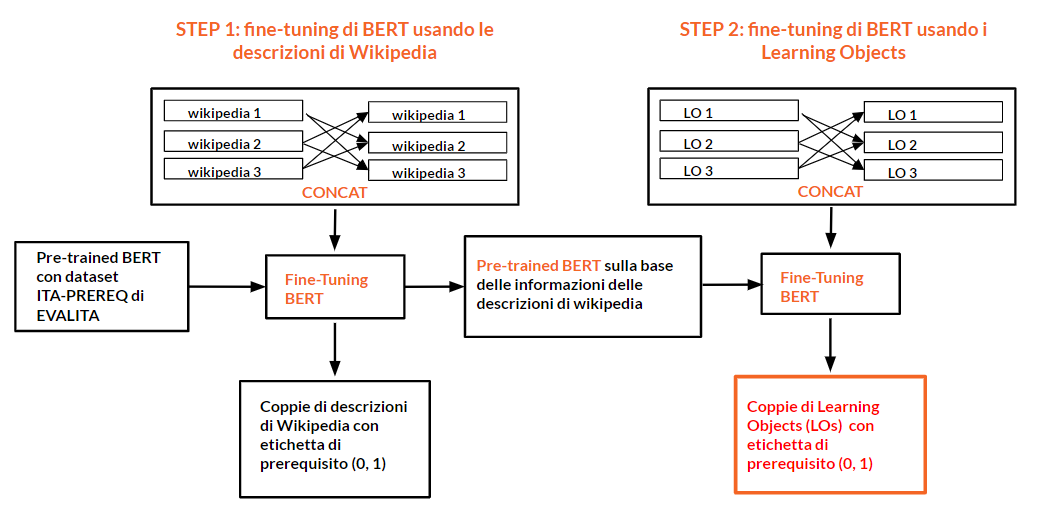

In [22]:
from IPython.display import display, Image
display(Image(filename='bert_fine_tuning.png'))

In [18]:
dataset = pd.read_csv(r"C:\Users\andre\OneDrive\Desktop\DATA\INFO PREREQUISITI\INFO_DATASET_COMPLETO_1024.csv", index_col = 0)
dataset = dataset.drop(columns= ['concept1', 'concept2', 'concept3','concept4', 'concept5', 'wiki1', 'wiki2', 'wiki4', 'wiki5'])
dataset

,title,text_preprocessed,best_ANN,best_ANN_cos_sim
0,Holiday STEM Activities for Kids,this resource includes activities that can int...,Spongelab is a science education website for t...,0.462783
1,Blockly Games,blockly games is a series of educational games...,Blockly is a client-side library for the progr...,0.645902
2,Day of AI,this resource is to support teachers and educa...,Creativity is a phenomenon whereby something n...,0.419912
3,Student Investigation Guide for Introduction t...,"in this book, you are going to engage in a ser...","A planet is a large, rounded astronomical body...",0.567468
4,Bridges to STEM Learning for Grades K-8,this course provides knowledge and skills in s...,OpenStax (formerly OpenStax College) is a nonp...,0.400543
...,...,...,...,...
28936,nanoHUBorg,"this site provides online simulations, learnin...","Nanomaterials describe, in principle, material...",0.535785
28937,The normal force,"in this simulation, you see, on the left, a pi...","Inversion therapy, or simply inversion, is the...",0.375144
28938,tiny Pants Photo Challenge,"in this activity, learners use basic measureme...",Earth science or geoscience includes all field...,0.503259
28939,A universe smaller than the observable,a universe smaller than the observable created...,"In set theory, when dealing with sets of infin...",0.311518
